### 线性回归
回归（regression）是能为一个或多个自变量与因变量之间关系建模的一类方法。 在自然科学和社会科学领域，回归经常用来表示输入和输出之间的关系。

输入包含$d$个特征的线性模型预测结果表示为:
$$\hat{y} = w_1 x_1 + ……+ w_dx_d + b$$

将特征向量放到向量$x \in \mathbb{R}^n$中，权重放入向量$w\in\mathbb{R}^d$中，上式可用点乘形式表示:
$$\hat{y} = w^Tx + b$$

用符号表示的矩阵$X \in \mathbb{R}^{n\times d} $其中$X$的每一行是一个样本，每一列是一种特征。线性回归用矩阵形式表示为:
$$\hat{y} = Xw + b$$

在开始寻找最好的模型参数$w$和$b$之前，还需要：
+ 一种模型质量的度量方式； 
+ 一种能够更新模型以提高模型预测质量的方法。

#### 损失函数
拟合模型之前，确定一个度量。损失函数用于度量目标值与预测值之间的差距。回归中常用的损失函数是平方误差函数，定义如下：
$$l^{(i)}(w, b) = \frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2$$
为一维情况下绘制图像：

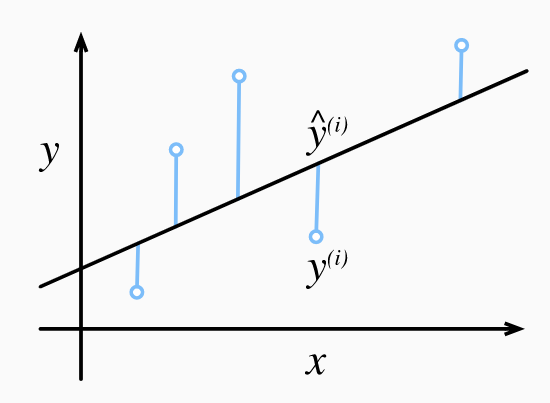


附上之前手写的线性回归完整公式推导过程：
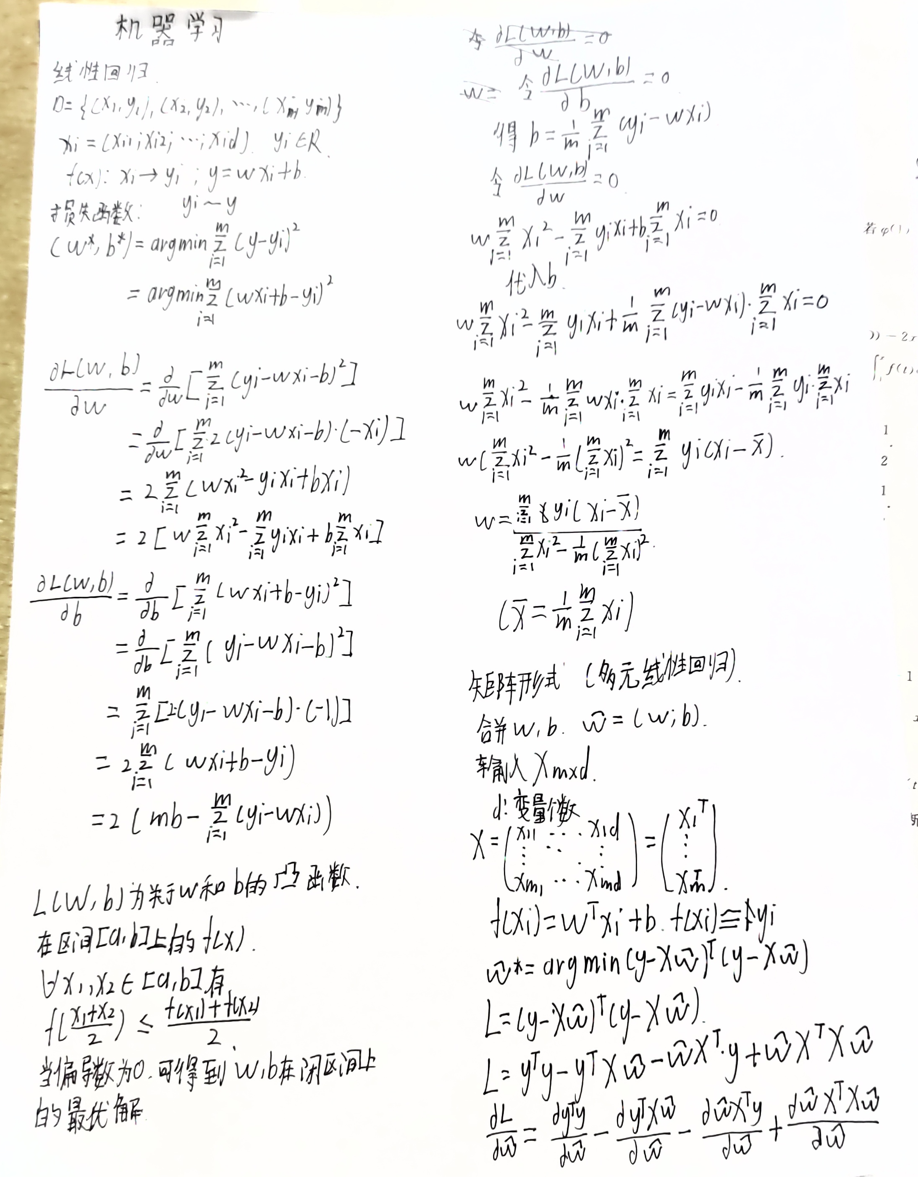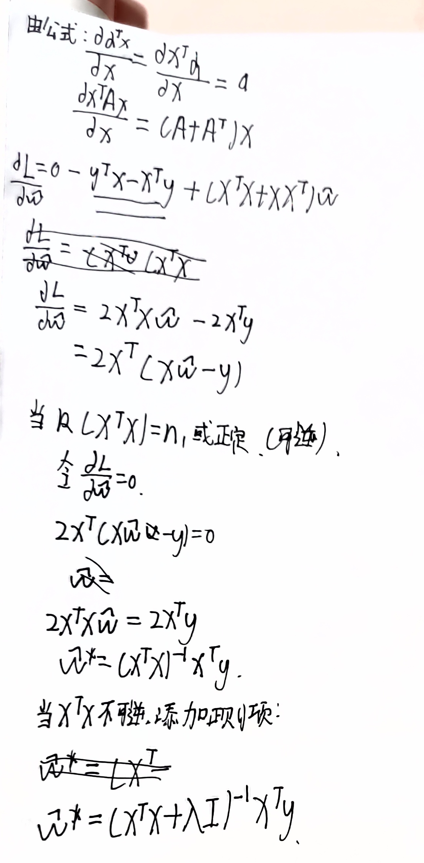

#### 随机梯度下降
在本书中用到随机梯度下降的方法，它通过不断地在损失函数递减的方向上更新参数来降低误差。在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降。在每次迭代中，首先随机抽样一个由固定数量的训练样本组成的小批量$\beta$,计算小批量的平均损失关于模型参数的梯度，将梯度乘以一个预先确定的正数$\eta$,并从当前参数的值中减掉。
该过程由如下公式表示:
$$(\mathbf{w}, b) \leftarrow(\mathbf{w}, b)-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w}, b)} l^{(i)}(\mathbf{w}, b)$$

#### 矢量化加速

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [4]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [5]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.24794 sec'

In [7]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

#### 正态分布的代码描述
（正态分布及其性质在概率论中比较常用，不过多赘述）

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

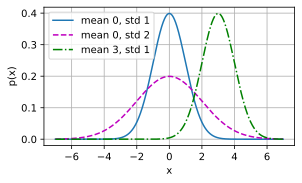

In [10]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

#### 线性回归的代码实现

In [11]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

生成包含1000个样本的数据集$X\in \mathbb{R}^{1000 \times2}$

使用模型参数$w=[2, -334]、b=4.2 噪声 \epsilon $及其标签:
$$\mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon$$

In [12]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

+ 查看数据分布

In [13]:
# 查看数据
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.6049,  0.5701]) 
label: tensor([-0.9622])


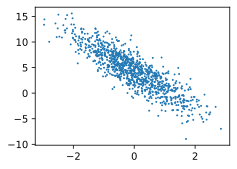

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

#### 读取数据集

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3400, -1.9509],
        [-0.0942, -1.3754],
        [-0.5440, -1.4164],
        [-1.1829,  0.2437],
        [-0.6970, -2.3750],
        [ 0.1409,  0.3479],
        [-0.8241, -0.7371],
        [ 0.7580,  0.7377],
        [ 0.8956,  0.8781],
        [-1.6561,  0.2658]]) 
 tensor([[11.5084],
        [ 8.6805],
        [ 7.9101],
        [ 0.9994],
        [10.8688],
        [ 3.2946],
        [ 5.0582],
        [ 3.2032],
        [ 2.9980],
        [-0.0170]])


#### 初始化模型参数

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### 定义模型

In [18]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 定义损失函数

In [19]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 定义损失函数

In [20]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。

In [21]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 训练过程
训练中重复梯度计算与更新直至完成

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028125
epoch 2, loss 0.000085
epoch 3, loss 0.000047


In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-2.8825e-04, -2.7418e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


### 使用pytorch接口实现线性回归
其他过程与代码实现类似，模型结构使用pytorch自带接口实现

In [24]:
# 生成数据集
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [25]:
#  读取数据集
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
next(iter(data_iter))

[tensor([[ 1.1033, -0.1117],
         [ 0.0805,  0.5910],
         [-0.1038, -0.3178],
         [-1.0639,  0.0107],
         [-0.2452,  0.1228],
         [ 0.7014,  0.5406],
         [ 0.5773,  0.0160],
         [ 2.6831,  0.1514],
         [ 0.2017,  0.7361],
         [-1.1964, -1.2090]]),
 tensor([[6.7701],
         [2.3722],
         [5.0748],
         [2.0418],
         [3.2872],
         [3.7666],
         [5.3049],
         [9.0535],
         [2.1085],
         [5.9134]])]

在PyTorch中，全连接层在Linear类中定义。 值得注意的是，我们将两个参数传递到nn.Linear中。 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [27]:
# 定义模型
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [28]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [29]:
# 定义损失函数
loss = nn.MSELoss()

In [30]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [31]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000291
epoch 2, loss 0.000101
epoch 3, loss 0.000101


In [32]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0004, -0.0007])
b的估计误差： tensor([0.0005])
